# Results Checker for Predictions

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import warnings

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

directory = 'C:/Users/99451/Desktop/MODEL/2025/dixon_coles_model_predictions/_predictions.xlsx'
predictions = pd.read_excel(directory)
predictions['League'] = predictions['League'].str.capitalize()

predictions.tail()

,League,Home,Away,FT1,FTX,FT2,FTR,DC1X,DC12,DCX2,1.5O,2.5O,3.5U,4.5U,BTTS,HT1,HTX,HT2,HTR,HTDC1X,HTDC12,HTDCX2,HT0.5O,HT1.5U,H0.5O,A0.5O,H1.5O,A1.5O,H2.5U,A2.5U
1459,Switzerland,Winterthur,FC Basel,9.74,16.54,73.71,0-1,26.28,83.45,90.25,66.42,41.72,78.90,91.02,29.63,6.19,49.53,44.22,0-0,55.72,50.41,93.75,53.41,82.91,36.81,84.90,7.81,56.36,98.84,70.60
1460,Switzerland,Luzern,Yverdon,66.71,16.63,16.64,1-0,83.34,83.35,33.27,75.94,54.42,67.88,83.84,47.37,32.97,45.90,21.10,0-0,78.87,54.07,67.00,61.69,77.13,86.69,56.83,59.87,20.57,67.17,94.64
1461,Turkey,Hatayspor,Kayserispor,25.53,29.96,44.50,1-1,55.49,70.03,74.46,79.44,52.93,69.31,84.85,58.20,41.62,44.80,13.45,0-0,86.42,55.07,58.25,65.80,67.65,69.48,79.96,33.26,47.76,88.23,78.13
1462,Turkey,Kasimpasa,Samsunspor,14.36,28.86,56.78,1-1,43.22,71.14,85.64,73.09,44.76,76.46,89.56,46.49,31.57,50.09,18.30,0-0,81.66,49.87,68.39,60.27,73.56,53.89,81.59,18.20,50.44,95.61,75.92
1463,Turkey,Goztepe,Trabzonspor,31.19,36.92,31.88,1-1,68.11,63.07,68.80,62.62,32.49,85.61,94.68,43.15,46.48,40.31,12.92,0-0,86.79,59.40,53.23,71.50,60.15,63.07,63.56,26.29,26.77,92.04,91.80


# Finding Game Results

In [2]:
final =  pd.DataFrame()
liqa = ''
unique_leagues = predictions['League'].unique().tolist()

for i in unique_leagues:
    URL = "https://www.soccerstats.com/results.asp?league=" + i + "&pmtype=bydate"
    page = requests.get(URL)
    liqa = i
    soup = BeautifulSoup(page.content, "html.parser")
    results = soup.find(id="btable")
    sth = results.find_all("tr", class_="odd")
    sth


    date, league, home, away, ft, ht = [], [], [], [], [],[]
    for i in sth:
        date.append(i.find_all("td", align = 'right')[0].get_text(strip=True))
        league.append(liqa.capitalize())
        home.append(i.find_all("td", align = 'right')[1].get_text(strip=True))
        away.append(i.find("td", align = "left").get_text(strip = True))
        ft.append(i.find_all("td", align = 'center')[0].get_text(strip = True))
        try:
            ht.append(i.find_all("td", align = 'center')[2].get_text(strip = True))
        except IndexError as e:
            ht.append('NA')#print("Last output before error occurred:", i.find_all("td", align = 'center'))

    data = {'Date': date, 'League': league,'Home': home, 'Away': away, 'FT': ft, 'HT': ht}

# Create a DataFrame from the dictionary
    df = pd.DataFrame(data)

# Replace empty strings with NaN
    #next_df = df[(df['Date'] == formatted_date) & (df['HT'] == '')]
    df.replace('', pd.NA, inplace=True)

# Drop rows with NaN values
    df_cleaned = df.dropna()

#For Half-Time Results
    hthg, htag = [], []
    for i in df_cleaned['HT']:
        if i == 'NA':
            hthg.append('NA')
            htag.append('NA')
        elif i == '+' or i == '-':
            hthg.append('NA')
            htag.append('NA')
        else:
            try:
                hthg.append(int(i[1]))
                htag.append(int(i[3]))
            except IndexError as e:
                print("Last output before error occurred:", i)



#For Full-Time Results
    hg, ag, tg = [], [], []
    for i in df_cleaned['FT']:
        if len(i) < 5 or ':' in i:
            hg.append('NA')
            ag.append('NA')
            tg.append('NA')
        else:
            try:
                hghg = int(i.split(' - ')[0])
                hg.append(hghg)
                agag = int(i.split(' - ')[1])
                ag.append(agag)
                tg.append(hghg + agag)
            except:
                print(hghg + agag)

    
    df_cleaned['FTHG'], df_cleaned['FTAG'], df_cleaned['FTTG'] = hg, ag, tg
    df_cleaned['HTHG'], df_cleaned['HTAG'] = hthg, htag
    df_cleaned['HTTG'] = df_cleaned['HTHG'] + df_cleaned['HTAG']
    
    final = pd.concat([final, df_cleaned], ignore_index=True)
    
final = final[final['HT'] != 'NA']

# Example: Fix the 'date' column by removing the weekday and extra punctuation
final['Date'] = final['Date'].str.extract(r'(\d{1,2} \w{3})')  # Extract day and month part
final['Date'] = final['Date'] + ' 2024'  # Append the year

# Convert to datetime format
final['Date'] = pd.to_datetime(final['Date'], format='%d %b %Y', errors='coerce')

# Filter rows before September 6th, 2024
final_filtered = final[final['Date'] >= pd.Timestamp('2024-09-06')]
combined = pd.concat([final_filtered.head(), final_filtered.tail()])

combined

,Date,League,Home,Away,FT,HT,FTHG,FTAG,FTTG,HTHG,HTAG,HTTG
39,2024-09-13,Spain,Real Betis,Leganes,2 - 0,(0-0),2,0,2,0,0,0
40,2024-09-14,Spain,Mallorca,Villarreal,1 - 2,(0-1),1,2,3,0,1,1
41,2024-09-14,Spain,Espanyol,Alaves,3 - 2,(1-1),3,2,5,1,1,2
42,2024-09-14,Spain,Sevilla FC,Getafe,1 - 0,(1-0),1,0,1,1,0,1
43,2024-09-14,Spain,Real Sociedad,Real Madrid,0 - 2,(0-0),0,2,2,0,0,0
5315,2024-10-23,Portugal2,FC Porto B,Mafra,2 - 1,(0-1),2,1,3,0,1,1
5316,2024-10-25,Portugal2,Pacos Ferreira,Vizela,1 - 1,(0-1),1,1,2,0,1,1
5317,2024-10-26,Portugal2,Penafiel,Academico Viseu,0 - 2,(0-0),0,2,2,0,0,0
5318,2024-10-26,Portugal2,Oliveirense,Chaves,0 - 3,(0-1),0,3,3,0,1,1
5319,2024-10-26,Portugal2,Feirense,Portimonense,1 - 1,(0-1),1,1,2,0,1,1


# Choosing the matches that are on the xlsx and taking their results

In [3]:
# Combine df and final based on 'League', 'Home', and 'Away'
combined_df = pd.merge(predictions, final_filtered, on=['League', 'Home', 'Away'], how='left')
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]
combined_df = combined_df.dropna(subset=['Date'])
combined_df = combined_df.drop_duplicates(subset=['Home', 'Away'])
combined_df = combined_df.reset_index(drop=True) #Regularize index of combined_df
combined_df.tail()

,League,Home,Away,FT1,FTX,FT2,FTR,DC1X,DC12,DCX2,1.5O,2.5O,3.5U,4.5U,BTTS,HT1,HTX,HT2,HTR,HTDC1X,HTDC12,HTDCX2,HT0.5O,HT1.5U,H0.5O,A0.5O,H1.5O,A1.5O,H2.5U,A2.5U,Date,FT,HT,FTHG,FTAG,FTTG,HTHG,HTAG,HTTG
1397,Scotland,Aberdeen,Dundee Utd,71.77,14.24,13.95,1-0,86.01,85.72,28.19,77.24,56.60,65.75,82.29,45.56,33.31,51.67,15.00,0-0,84.98,48.31,66.67,54.70,81.45,88.68,53.73,64.08,18.08,62.73,95.62,2024-10-26,1 - 0,(0-0),1.0,0.0,1.0,0.0,0.0,0.0
1398,Spain,Valladolid,Villarreal,21.23,25.39,53.31,1-1,46.62,74.54,78.70,92.60,73.95,46.18,65.66,73.33,17.94,39.96,41.84,0-0,57.90,59.78,81.80,73.95,56.85,77.84,90.37,44.50,67.93,80.59,58.33,2024-10-26,1 - 2,(0-1),1.0,2.0,3.0,0.0,1.0,1.0
1399,Spain,Rayo Vallecano,Alaves,62.29,26.30,11.36,1-1,88.59,73.65,37.66,85.31,60.29,62.02,79.46,57.42,53.21,39.91,6.60,0-0,93.12,59.81,46.51,66.76,67.73,88.72,60.70,64.16,24.01,62.64,93.09,2024-10-26,1 - 0,(0-0),1.0,0.0,1.0,0.0,0.0,0.0
1400,Spain,Las Palmas,Girona,27.36,36.15,36.49,1-1,63.51,63.85,72.64,77.92,47.83,73.88,87.93,57.32,25.63,47.72,26.60,0-0,73.35,52.23,74.32,64.18,69.63,69.76,75.11,33.59,40.50,88.03,83.57,2024-10-26,1 - 0,(1-0),1.0,0.0,1.0,1.0,0.0,1.0
1401,Turkey,Hatayspor,Kayserispor,25.53,29.96,44.50,1-1,55.49,70.03,74.46,79.44,52.93,69.31,84.85,58.20,41.62,44.80,13.45,0-0,86.42,55.07,58.25,65.80,67.65,69.48,79.96,33.26,47.76,88.23,78.13,2024-10-26,0 - 1,(0-0),0.0,1.0,1.0,0.0,0.0,0.0


# Checking Predictions To See if Correct or Not

In [4]:
ftrs = []
ftscs = []
dcs = []
overs15 = []
overs25 = []
unders35 = []
unders45 = []
bttss = []
htrs = []
htdcs = []
htscs = []
htovers05 = []
htunders15 = []
homeovers05 = []
awayovers05 = []
homeovers15 = []
awayovers15 = []
homeunders25 = []
awayunders25 = []

for i in range(len(combined_df)):
    full_time_results = [combined_df['FT1'].iloc[i], combined_df['FTX'].iloc[i], combined_df['FT2'].iloc[i]]
    if full_time_results.index(max(full_time_results)) == 0 and combined_df['FTHG'].iloc[i] > combined_df['FTAG'].iloc[i]:
        ftrs.append(1)
    elif full_time_results.index(max(full_time_results)) == 1 and combined_df['FTHG'].iloc[i] == combined_df['FTAG'].iloc[i]:
        ftrs.append(1)
    elif full_time_results.index(max(full_time_results)) == 2 and combined_df['FTHG'].iloc[i] < combined_df['FTAG'].iloc[i]:
        ftrs.append(1)
    else:
        ftrs.append(0)
    
    if combined_df['FTR'].iloc[i] == combined_df['FT'].iloc[i].replace(' ', ''):
        ftscs.append(1)
    else:
        ftscs.append(0)

    double_chances = [combined_df['DC1X'].iloc[i], combined_df['DC12'].iloc[i], combined_df['DCX2'].iloc[i]]
    if double_chances.index(max(double_chances)) == 0 and combined_df['FTHG'].iloc[i] >= combined_df['FTAG'].iloc[i]:
        dcs.append(1)
    elif double_chances.index(max(double_chances)) == 2 and combined_df['FTHG'].iloc[i] <= combined_df['FTAG'].iloc[i]:
        dcs.append(1)
    elif double_chances.index(max(double_chances)) == 1 and combined_df['FTHG'].iloc[i] != combined_df['FTAG'].iloc[i]:
        dcs.append(1)
    else:
        dcs.append(0)
    
    if combined_df['1.5O'].iloc[i] > 50 and combined_df['FTTG'].iloc[i] > 1.5:
        overs15.append(1)
    elif combined_df['1.5O'].iloc[i] < 50 and combined_df['FTTG'].iloc[i] < 1.5:
        overs15.append(1)
    else:
        overs15.append(0)
    
    if combined_df['2.5O'].iloc[i] > 50 and combined_df['FTTG'].iloc[i] > 2.5:
        overs25.append(1)
    elif combined_df['2.5O'].iloc[i] < 50 and combined_df['FTTG'].iloc[i] < 2.5:
        overs25.append(1)
    else:
        overs25.append(0)
    
    if combined_df['3.5U'].iloc[i] > 50 and combined_df['FTTG'].iloc[i] < 3.5:
        unders35.append(1)
    elif combined_df['3.5U'].iloc[i] < 50 and combined_df['FTTG'].iloc[i] > 3.5:
        unders35.append(1)
    else:
        unders35.append(0)
    
    if combined_df['4.5U'].iloc[i] > 50 and combined_df['FTTG'].iloc[i] < 4.5:
        unders45.append(1)
    elif combined_df['4.5U'].iloc[i] < 50 and combined_df['FTTG'].iloc[i] > 4.5:
        unders45.append(1)
    else:
        unders45.append(0)

    if combined_df['BTTS'].iloc[i] > 50 and (combined_df['FTHG'].iloc[i] != 0 and combined_df['FTAG'].iloc[i] != 0):
        bttss.append(1)
    elif combined_df['BTTS'].iloc[i] < 50 and (combined_df['FTHG'].iloc[i] == 0 or combined_df['FTAG'].iloc[i] == 0):
        bttss.append(1)
    else:
        bttss.append(0)
    
    half_time_results = [combined_df['HT1'].iloc[i], combined_df['HTX'].iloc[i], combined_df['HT2'].iloc[i]]
    if half_time_results.index(max(half_time_results)) == 0 and combined_df['HTHG'].iloc[i] > combined_df['HTAG'].iloc[i]:
        htrs.append(1)
    elif half_time_results.index(max(half_time_results)) == 1 and combined_df['HTHG'].iloc[i] == combined_df['HTAG'].iloc[i]:
        htrs.append(1)
    elif half_time_results.index(max(half_time_results)) == 2 and combined_df['HTHG'].iloc[i] < combined_df['HTAG'].iloc[i]:
        htrs.append(1)
    else:
        htrs.append(0)
    
    if combined_df['HTR'].iloc[i] == combined_df['HT'].iloc[i].replace('(', '').replace(')', ''):
        htscs.append(1)
    else:
        htscs.append(0)
    
    ht_double_chances = [combined_df['HTDC1X'].iloc[i], combined_df['HTDC12'].iloc[i], combined_df['HTDCX2'].iloc[i]]
    if ht_double_chances.index(max(ht_double_chances)) == 0 and combined_df['HTHG'].iloc[i] >= combined_df['HTAG'].iloc[i]:
        htdcs.append(1)
    elif ht_double_chances.index(max(ht_double_chances)) == 2 and combined_df['HTHG'].iloc[i] <= combined_df['HTAG'].iloc[i]:
        htdcs.append(1)
    elif ht_double_chances.index(max(ht_double_chances)) == 1 and combined_df['HTHG'].iloc[i] != combined_df['HTAG'].iloc[i]:
        htdcs.append(1)
    else:
        htdcs.append(0)
    
    if combined_df['HT0.5O'].iloc[i] > 50 and combined_df['HTTG'].iloc[i] > 0.5:
        htovers05.append(1)
    elif combined_df['HT0.5O'].iloc[i] < 50 and combined_df['HTTG'].iloc[i] < 0.5:
        htovers05.append(1)
    else:
        htovers05.append(0)
    
    if combined_df['HT1.5U'].iloc[i] > 50 and combined_df['HTTG'].iloc[i] < 1.5:
        htunders15.append(1)
    elif combined_df['HT1.5U'].iloc[i] < 50 and combined_df['HTTG'].iloc[i] > 1.5:
        htunders15.append(1)
    else:
        htunders15.append(0)
    
    if combined_df['H0.5O'].iloc[i] > 50 and combined_df['FTHG'].iloc[i] > 0.5:
        homeovers05.append(1)
    elif combined_df['H0.5O'].iloc[i] < 50 and combined_df['FTHG'].iloc[i] < 0.5:
        homeovers05.append(1)
    else:
        homeovers05.append(0)

    if combined_df['H1.5O'].iloc[i] > 50 and combined_df['FTHG'].iloc[i] > 1.5:
        homeovers15.append(1)
    elif combined_df['H1.5O'].iloc[i] < 50 and combined_df['FTHG'].iloc[i] < 1.5:
        homeovers15.append(1)
    else:
        homeovers15.append(0)
    
    if combined_df['A0.5O'].iloc[i] > 50 and combined_df['FTAG'].iloc[i] > 0.5:
        awayovers05.append(1)
    elif combined_df['A0.5O'].iloc[i] < 50 and combined_df['FTAG'].iloc[i] < 0.5:
        awayovers05.append(1)
    else:
        awayovers05.append(0)

    if combined_df['A1.5O'].iloc[i] > 50 and combined_df['FTAG'].iloc[i] > 1.5:
        awayovers15.append(1)
    elif combined_df['A1.5O'].iloc[i] < 50 and combined_df['FTAG'].iloc[i] < 1.5:
        awayovers15.append(1)
    else:
        awayovers15.append(0)
    
    if combined_df['H2.5U'].iloc[i] > 50 and combined_df['FTHG'].iloc[i] < 2.5:
        homeunders25.append(1)
    elif combined_df['H2.5U'].iloc[i] < 50 and combined_df['FTHG'].iloc[i] > 2.5:
        homeunders25.append(1)
    else:
        homeunders25.append(0)
    
    if combined_df['A2.5U'].iloc[i] > 50 and combined_df['FTAG'].iloc[i] < 2.5:
        awayunders25.append(1)
    elif combined_df['A2.5U'].iloc[i] < 50 and combined_df['FTAG'].iloc[i] > 2.5:
        awayunders25.append(1)
    else:
        awayunders25.append(0)

combined_df['FTRP'] = ftrs
combined_df['FTSP'] = ftscs
combined_df['FTDCP'] = dcs
combined_df['1.5OP'] = overs15
combined_df['2.5OP'] = overs25
combined_df['3.5UP'] = unders35
combined_df['4.5UP'] = unders45
combined_df['BTTSP'] = bttss
combined_df['HTRP'] = htrs
combined_df['HTSP'] = htscs
combined_df['HTDCP'] = htdcs
combined_df['HT0.5OP'] = htovers05
combined_df['HT1.5UP'] = htunders15
combined_df['H0.5OP'] = homeovers05
combined_df['A0.5OP'] = awayovers05
combined_df['H1.5OP'] = homeovers15
combined_df['A1.5OP'] = awayovers15
combined_df['H2.5UP'] = homeunders25
combined_df['A2.5UP'] = awayunders25 

combined_df.tail()


,League,Home,Away,FT1,FTX,FT2,FTR,DC1X,DC12,DCX2,1.5O,2.5O,3.5U,4.5U,BTTS,HT1,HTX,HT2,HTR,HTDC1X,HTDC12,HTDCX2,HT0.5O,HT1.5U,H0.5O,A0.5O,H1.5O,A1.5O,H2.5U,A2.5U,Date,FT,HT,FTHG,FTAG,FTTG,HTHG,HTAG,HTTG,FTRP,FTSP,FTDCP,1.5OP,2.5OP,3.5UP,4.5UP,BTTSP,HTRP,HTSP,HTDCP,HT0.5OP,HT1.5UP,H0.5OP,A0.5OP,H1.5OP,A1.5OP,H2.5UP,A2.5UP
1397,Scotland,Aberdeen,Dundee Utd,71.77,14.24,13.95,1-0,86.01,85.72,28.19,77.24,56.60,65.75,82.29,45.56,33.31,51.67,15.00,0-0,84.98,48.31,66.67,54.70,81.45,88.68,53.73,64.08,18.08,62.73,95.62,2024-10-26,1 - 0,(0-0),1.0,0.0,1.0,0.0,0.0,0.0,1,1,1,0,0,1,1,1,1,1,1,0,1,1,0,0,1,1,1
1398,Spain,Valladolid,Villarreal,21.23,25.39,53.31,1-1,46.62,74.54,78.70,92.60,73.95,46.18,65.66,73.33,17.94,39.96,41.84,0-0,57.90,59.78,81.80,73.95,56.85,77.84,90.37,44.50,67.93,80.59,58.33,2024-10-26,1 - 2,(0-1),1.0,2.0,3.0,0.0,1.0,1.0,1,0,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1
1399,Spain,Rayo Vallecano,Alaves,62.29,26.30,11.36,1-1,88.59,73.65,37.66,85.31,60.29,62.02,79.46,57.42,53.21,39.91,6.60,0-0,93.12,59.81,46.51,66.76,67.73,88.72,60.70,64.16,24.01,62.64,93.09,2024-10-26,1 - 0,(0-0),1.0,0.0,1.0,0.0,0.0,0.0,1,0,1,0,0,1,1,0,0,1,1,0,1,1,0,0,1,1,1
1400,Spain,Las Palmas,Girona,27.36,36.15,36.49,1-1,63.51,63.85,72.64,77.92,47.83,73.88,87.93,57.32,25.63,47.72,26.60,0-0,73.35,52.23,74.32,64.18,69.63,69.76,75.11,33.59,40.50,88.03,83.57,2024-10-26,1 - 0,(1-0),1.0,0.0,1.0,1.0,0.0,1.0,0,0,0,0,1,1,1,0,0,0,0,1,1,1,0,1,1,1,1
1401,Turkey,Hatayspor,Kayserispor,25.53,29.96,44.50,1-1,55.49,70.03,74.46,79.44,52.93,69.31,84.85,58.20,41.62,44.80,13.45,0-0,86.42,55.07,58.25,65.80,67.65,69.48,79.96,33.26,47.76,88.23,78.13,2024-10-26,0 - 1,(0-0),0.0,1.0,1.0,0.0,0.0,0.0,1,0,1,0,0,1,1,0,1,1,1,0,1,0,1,1,1,1,1


# Checking Statistics Now

Number of games:  1402


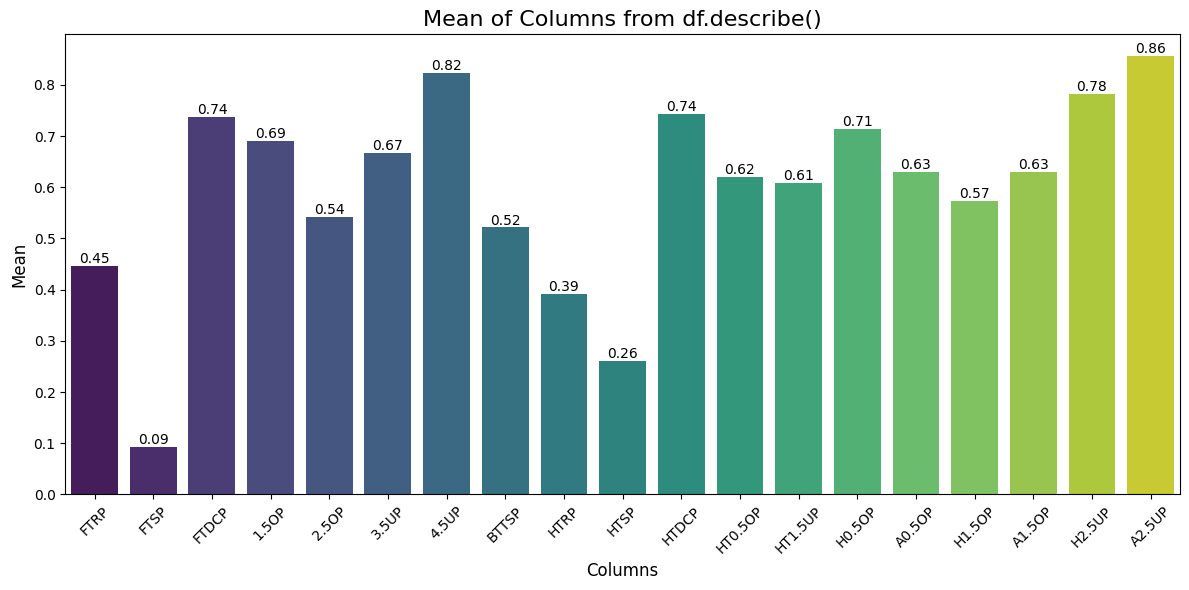

In [5]:
stats_df = combined_df[['League', 'Home', 'Away', 'FTRP', 'FTSP', 'FTDCP', '1.5OP',	'2.5OP', '3.5UP', '4.5UP', 'BTTSP',	
                        'HTRP',	'HTSP',	'HTDCP', 'HT0.5OP',	'HT1.5UP', 'H0.5OP', 'A0.5OP', 'H1.5OP', 'A1.5OP', 'H2.5UP',
                        'A2.5UP']]

import matplotlib.pyplot as plt
import seaborn as sns

print('Number of games: ', len(combined_df))
# Get the summary statistics
desc = stats_df.describe()

# Extract the 'mean' row
means = desc.loc['mean']

# Plotting the means using seaborn or matplotlib
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=means.index, y=means.values, palette="viridis")

# Add titles and labels
plt.title('Mean of Columns from df.describe()', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Mean', fontsize=12)

# Rotate the x labels if necessary for better readability
plt.xticks(rotation=45)

# Add text labels to each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center',
                xytext=(0, 5),  # offset label from bar
                textcoords='offset points')

# Show the plot
plt.tight_layout()
plt.show()

# Checking Threshold Values

In [6]:
import numpy as np

# Calculate the optimal threshold and best accuracy
def calculate_threshold(percentages, correctness):
    # Normalize the percentages to be between 0 and 1
    percentages = [p / 100 for p in percentages]

    best_threshold = 0
    best_accuracy = 0
    for threshold in np.unique(percentages):
        predicted_correctness = [1 if p >= threshold else 0 for p in percentages]
        accuracy = np.mean(np.array(predicted_correctness) == np.array(correctness))
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
    return round(best_threshold * 100, 2), round(best_accuracy * 100, 2)

print('Number of games: ', len(combined_df))
dc1x = combined_df[combined_df['DC1X'] >= combined_df[['DC12', 'DCX2']].max(axis=1)]
dc12 = combined_df[combined_df['DC12'] >= combined_df[['DC1X', 'DCX2']].max(axis=1)]
dcx2 = combined_df[combined_df['DCX2'] >= combined_df[['DC1X', 'DC12']].max(axis=1)]

htdc1x = combined_df[combined_df['HTDC1X'] >= combined_df[['HTDC12', 'HTDCX2']].max(axis=1)]
htdc12 = combined_df[combined_df['HTDC12'] >= combined_df[['HTDC1X', 'HTDCX2']].max(axis=1)]
htdcx2 = combined_df[combined_df['HTDCX2'] >= combined_df[['HTDC1X', 'HTDC12']].max(axis=1)]

dc1x_t, dc1x_a = calculate_threshold(dc1x['DC1X'], dc1x['FTDCP'])
dc12_t, dc12_a = calculate_threshold(dc12['DC12'], dc12['FTDCP'])
dcx2_t, dcx2_a = calculate_threshold(dcx2['DCX2'], dcx2['FTDCP'])

htdc1x_t, htdc1x_a = calculate_threshold(htdc1x['HTDC1X'], htdc1x['HTDCP'])
htdc12_t, htdc12_a = calculate_threshold(htdc12['HTDC12'], htdc12['HTDCP'])
htdcx2_t, htdcx2_a = calculate_threshold(htdcx2['HTDCX2'], htdcx2['HTDCP'])

print(f'DC1X threshold value: {dc1x_t}, accuracy: {dc1x_a}, games {len(dc1x)}      HTDC1X threshold value: {htdc1x_t}, accuracy: {htdc1x_a}, games {len(htdc1x)}')
print(f'DC12 threshold value: {dc12_t}, accuracy: {dc12_a}, games {len(dc12)}      HTDC12 threshold value: {htdc12_t}, accuracy: {htdc12_a}, games {len(htdc12)}')
print(f'DCX2 threshold value: {dcx2_t}, accuracy: {dcx2_a}, games {len(dcx2)}      HTDCX2 threshold value: {htdcx2_t}, accuracy: {htdcx2_a}, games {len(htdcx2)}')
print(" ")

ft1 = combined_df[combined_df['FT1'] >= combined_df[['FTX', 'FT2']].max(axis=1)]
ftx = combined_df[combined_df['FTX'] >= combined_df[['FT1', 'FT2']].max(axis=1)]
ftx = ftx[ftx['FTX'] < 100]
ft2 = combined_df[combined_df['FT2'] >= combined_df[['FT1', 'FTX']].max(axis=1)]

ht1 = combined_df[combined_df['HT1'] >= combined_df[['HTX', 'HT2']].max(axis=1)]
htx = combined_df[combined_df['HTX'] >= combined_df[['HT1', 'HT2']].max(axis=1)]
htx = htx[htx['HTX'] < 100]
ht2 = combined_df[combined_df['HT2'] >= combined_df[['HT1', 'HTX']].max(axis=1)]

ft1_t, ft1_a = calculate_threshold(ft1['FT1'], ft1['FTRP'])
ftx_t, ftx_a = calculate_threshold(ftx['FTX'], ftx['FTRP'])
ft2_t, ft2_a = calculate_threshold(ft2['FT2'], ft2['FTRP'])

ht1_t, ht1_a = calculate_threshold(ht1['HT1'], ht1['HTRP'])
htx_t, htx_a = calculate_threshold(htx['HTX'], htx['HTRP'])
ht2_t, ht2_a = calculate_threshold(ht2['HT2'], ht2['HTRP'])

print(f'FT1 threshold value: {ft1_t}, accuracy: {ft1_a}, games {len(ft1)}       HT1 threshold value: {ht1_t}, accuracy: {ht1_a}, games {len(ht1)}')
print(f'FTX threshold value: {ftx_t}, accuracy: {ftx_a}, games {len(ftx)}       HTX threshold value: {htx_t}, accuracy: {htx_a}, games {len(htx)}')
print(f'FT2 threshold value: {ft2_t}, accuracy: {ft2_a}, games {len(ft2)}       HT2 threshold value: {ht2_t}, accuracy: {ht2_a}, games {len(ht2)}')
print(" ")

over_15 = combined_df[combined_df['1.5O'] > 50]
under_15 = combined_df[combined_df['1.5O'] <= 50]

htover_05 = combined_df[combined_df['HT0.5O'] > 50]
htunder_05 = combined_df[combined_df['HT0.5O'] <= 50]

o15_t, o15_a = calculate_threshold(over_15['1.5O'], over_15['1.5OP'])
u15_t, u15_a = calculate_threshold(under_15['1.5O'], under_15['1.5OP'])
ht05o_t, ht05o_a = calculate_threshold(htover_05['HT0.5O'], htover_05['HT0.5OP'])
ht05u_t, ht05u_a = calculate_threshold(htunder_05['HT0.5O'], htunder_05['HT0.5OP'])

print(f'1.5Over threshold value: {o15_t}, accuracy: {o15_a}, games {len(over_15)}       HTOver0.5 threshold value: {ht05o_t}, accuracy: {ht05o_a}, games {len(htover_05)}')
print(f'1.5Under threshold value: {u15_t}, accuracy: {u15_a}, games {len(under_15)}     HTUnder0.5 threshold value: {ht05u_t}, accuracy: {ht05u_a}, games {len(htunder_05)}')
print(" ")

over_25 = combined_df[combined_df['2.5O'] > 50]
under_25 = combined_df[combined_df['2.5O'] <= 50]

htover_15 = combined_df[combined_df['HT1.5U'] <= 50]
htunder_15 = combined_df[combined_df['HT1.5U'] > 50]

o25_t, o25_a = calculate_threshold(over_25['2.5O'], over_25['2.5OP'])
u25_t, u25_a = calculate_threshold(under_25['2.5O'], under_25['2.5OP'])
ht15o_t, ht15o_a = calculate_threshold(htover_15['HT1.5U'], htover_15['HT1.5UP'])
ht15u_t, ht15u_a = calculate_threshold(htunder_15['HT1.5U'], htunder_15['HT1.5UP'])

print(f'2.5Over threshold value: {o25_t}, accuracy: {o25_a}, games {len(over_25)}       HTOver1.5 threshold value: {ht15o_t}, accuracy: {ht15o_a}, games {len(htover_15)}')
print(f'2.5Under threshold value: {u25_t}, accuracy: {u25_a}, games {len(under_25)}     HTUnder1.5 threshold value: {ht15u_t}, accuracy: {ht15u_a}, games {len(htunder_15)}')
print(" ")

over_35 = combined_df[combined_df['3.5U'] <= 50]
under_35 = combined_df[combined_df['3.5U'] > 50]

home_over_05 = combined_df[combined_df['H0.5O'] > 50]
home_under_05 = combined_df[combined_df['H0.5O'] <= 50]

o35_t, o35_a = calculate_threshold(over_35['3.5U'], over_35['3.5UP'])
u35_t, u35_a = calculate_threshold(under_35['3.5U'], under_35['3.5UP'])

hover_t, hover_a = calculate_threshold(home_over_05['H0.5O'], home_over_05['H0.5OP'])
hunder_t, hunder_a = calculate_threshold(home_under_05['H0.5O'], home_under_05['H0.5OP'])

print(f'3.5Over threshold value: {o35_t}, accuracy: {o35_a} games {len(over_35)}        HomeOver0.5 threshold: {hover_t}, accuracy: {hover_a}, games {len(home_over_05)}')
print(f'3.5Under threshold value: {u35_t}, accuracy: {u35_a} games {len(under_35)}      HomeUnder0.5 threshold: {hunder_t}, accuracy: {hunder_a}, games {len(home_under_05)}')
print(" ")

over_45 = combined_df[combined_df['4.5U'] <= 50]
under_45 = combined_df[combined_df['4.5U'] > 50]

away_over_05 = combined_df[combined_df['A0.5O'] > 50]
away_under_05 = combined_df[combined_df['A0.5O'] <= 50]

o45_t, o45_a = calculate_threshold(over_45['4.5U'], over_45['4.5UP'])
u45_t, u45_a = calculate_threshold(under_45['4.5U'], under_45['4.5UP'])
aover_t, aover_a = calculate_threshold(away_over_05['A0.5O'], away_over_05['A0.5OP'])
aunder_t, aunder_a = calculate_threshold(away_under_05['A0.5O'], away_under_05['A0.5OP'])

print(f'4.5Over threshold value: {o45_t}, accuracy: {o45_a}, games {len(over_45)}       AwayOver0.5 threshold: {aover_t}, accuracy: {aover_a}, games {len(away_over_05)}')
print(f'4.5Under threshold value: {u45_t}, accuracy: {u45_a}, games {len(under_45)}     AwayUnder0.5 threshold: {aunder_t}, accuracy: {aunder_a}, games {len(away_under_05)}')
print(" ")

btts = combined_df[combined_df['BTTS'] > 50]
otts = combined_df[combined_df['BTTS'] <= 50]

home_over_15 = combined_df[combined_df['H1.5O'] > 50]
home_under_15 = combined_df[combined_df['H1.5O'] <= 50]
away_over_15 = combined_df[combined_df['A1.5O'] > 50]
away_under_15 = combined_df[combined_df['A1.5O'] <= 50]

btts_t, btts_a = calculate_threshold(btts['BTTS'], btts['BTTSP'])
otts_t, otts_a = calculate_threshold(otts['BTTS'], otts['BTTSP'])
hover15_t, hover15_a = calculate_threshold(home_over_15['H1.5O'], home_over_15['H1.5OP'])
hunder15_t, hunder15_a = calculate_threshold(home_under_15['H1.5O'], home_under_15['H1.5OP'])
aover15_t, aover15_a = calculate_threshold(away_over_15['A1.5O'], away_over_15['A1.5OP'])
aunder15_t, aunder15_a = calculate_threshold(away_under_15['A1.5O'], away_under_15['A1.5OP'])

print(f'BTTS threshold value: {btts_t}, accuracy: {btts_a}, games: {len(btts)},     HomeOver1.5 T: {hover15_t}, A: {hover15_a}, G: {len(home_over_15)} HomeUnder1.5 T: {hunder15_t}, A: {hunder15_a}, G:{len(home_under_15)}')
print(f'OTTS threshold value: {otts_t}, accuracy: {otts_a}, games: {len(otts)}      AwayOver1.5 T: {aover15_t}, A: {aover15_a}, G: {len(away_over_15)} AwayUnder1.5 T: {aunder15_t}, A: {aunder15_a}, G:{len(away_under_15)}')
print(" ")

Number of games:  1402
DC1X threshold value: 66.7, accuracy: 79.49, games 629      HTDC1X threshold value: 9.04, accuracy: 78.82, games 798
DC12 threshold value: 68.34, accuracy: 73.24, games 411      HTDC12 threshold value: 76.06, accuracy: 61.9, games 84
DCX2 threshold value: 49.08, accuracy: 64.64, games 362      HTDCX2 threshold value: 0.08, accuracy: 70.94, games 523
 
FT1 threshold value: 52.73, accuracy: 58.2, games 768       HT1 threshold value: 80.05, accuracy: 59.91, games 434
FTX threshold value: 88.16, accuracy: 68.05, games 169       HTX threshold value: 80.31, accuracy: 56.7, games 702
FT2 threshold value: 84.34, accuracy: 63.79, games 464       HT2 threshold value: 81.62, accuracy: 75.4, games 248
 
1.5Over threshold value: 50.67, accuracy: 74.47, games 1234       HTOver0.5 threshold value: 50.1, accuracy: 70.21, games 1111
1.5Under threshold value: 49.76, accuracy: 69.64, games 168     HTUnder0.5 threshold value: 50.0, accuracy: 68.38, games 291
 
2.5Over threshold valu

# Checking League Stats

In [7]:
df_dropped = stats_df.drop(columns=['Home', 'Away'])

# Ensure 'League' is treated as categorical if needed
df_dropped['League'] = df_dropped['League'].astype('category')

# Group by 'League' and calculate mean for numeric columns
grouped_means = df_dropped.groupby('League').mean()

# Reset index to include 'League' as a column in the result
grouped_means = grouped_means.reset_index()

#Calculate average row-vise
numeric_cols = grouped_means.select_dtypes(include='number')
grouped_means['Average'] = numeric_cols.mean(axis=1)
league_counts = df_dropped.groupby('League').size().reset_index(name='Matches')
grouped_df = grouped_means.merge(league_counts, on='League', how='left')

# Reorder the columns: 'League', then 'count', followed by the mean columns
columns = ['League', 'Average', 'Matches'] + [col for col in grouped_df.columns if col not in ['League', 'Average', 'Matches']]

# Reassign the DataFrame with reordered columns
grouped_df = grouped_df[columns]
grouped_df = grouped_df[grouped_df['Matches'] > 9]
grouped_df.sort_values(by = 'Average', ascending = False)


,League,Average,Matches,FTRP,FTSP,FTDCP,1.5OP,2.5OP,3.5UP,4.5UP,BTTSP,HTRP,HTSP,HTDCP,HT0.5OP,HT1.5UP,H0.5OP,A0.5OP,H1.5OP,A1.5OP,H2.5UP,A2.5UP
4,Brazil,0.654306,44,0.477273,0.204545,0.772727,0.613636,0.522727,0.750000,0.909091,0.545455,0.613636,0.409091,0.909091,0.636364,0.681818,0.772727,0.500000,0.613636,0.772727,0.772727,0.954545
33,Spain,0.642105,55,0.490909,0.109091,0.781818,0.618182,0.600000,0.763636,0.818182,0.472727,0.563636,0.363636,0.745455,0.654545,0.781818,0.672727,0.545455,0.654545,0.781818,0.836364,0.945455
35,Sweden,0.639281,41,0.439024,0.073171,0.756098,0.780488,0.560976,0.853659,0.975610,0.487805,0.365854,0.341463,0.804878,0.536585,0.682927,0.707317,0.609756,0.585366,0.756098,0.902439,0.926829
38,Usa,0.635294,85,0.494118,0.082353,0.823529,0.858824,0.623529,0.611765,0.776471,0.647059,0.470588,0.211765,0.788235,0.741176,0.647059,0.835294,0.788235,0.552941,0.552941,0.752941,0.811765
0,Argentina,0.630656,57,0.456140,0.105263,0.701754,0.561404,0.614035,0.859649,0.929825,0.491228,0.543860,0.368421,0.807018,0.649123,0.701754,0.614035,0.438596,0.543860,0.842105,0.824561,0.929825
3,Belgium,0.618777,37,0.378378,0.189189,0.702703,0.756757,0.648649,0.729730,0.837838,0.513514,0.540541,0.351351,0.729730,0.648649,0.378378,0.702703,0.621622,0.594595,0.702703,0.810811,0.918919
29,Portugal,0.614035,30,0.500000,0.066667,0.900000,0.533333,0.466667,0.666667,0.866667,0.600000,0.433333,0.266667,0.833333,0.633333,0.700000,0.633333,0.600000,0.666667,0.700000,0.766667,0.833333
10,England3,0.610048,88,0.500000,0.102273,0.704545,0.693182,0.590909,0.681818,0.795455,0.568182,0.397727,0.284091,0.761364,0.625000,0.636364,0.693182,0.659091,0.590909,0.613636,0.784091,0.909091
23,Mexico,0.609312,52,0.442308,0.134615,0.653846,0.576923,0.596154,0.730769,0.788462,0.596154,0.384615,0.346154,0.750000,0.673077,0.711538,0.692308,0.519231,0.653846,0.653846,0.788462,0.884615
36,Switzerland,0.609312,26,0.423077,0.076923,0.692308,0.692308,0.500000,0.653846,0.846154,0.615385,0.423077,0.307692,0.807692,0.730769,0.500000,0.884615,0.538462,0.576923,0.653846,0.730769,0.923077
